In [1]:
import re
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from whatsparser import WhatsParser

# The effect of residency programs on hanging out with friends

Starting a residency program is one of the most important moment in the life of a medicine student. A stage classically characterized by rising responsibilities and a sharp decreased in finding time to hang out with friends (even in their birthdays). While the effects on starting a residency program on personal life are well known, only anecdotal evidence can be found around the literature. We aim to identify and measure the negative impact that starting a residency program has on finding time to hang out with friends.

## Importing data form WhatsApp

We parsed all messages from one whatsapp group made up of 5 college graduates (medicine school), 3 of them just started a residency program during june 2018.

In [4]:
data = WhatsParser('./assets/data.txt').to_dataframe() # to keep privacy, this file will not be uploaded

## Searching for keywords inside messages

All keywords defined are related in one way or another to messages asking to hang out.

In [5]:
targets = [r'\bbirras?\b', r'\bcervezas?\b',r'\brustico\b', r'\bsalir\b', r'\btomar\b', r'\bartesanal(es)?\b', 
          r'\basado\b', r'\balcohol\b', r'\bjoda\b', r'\bpatagonia\b', r'\bheineken\b', r'\bgrolsch\b', 
          r'\bimperial\b', r'\bvino\b', r'\bpintas?\b', r'\bhappy(\shour)?\b', r'\bjerome\b', r'\bbirritas?\b',
          r'\btradicion\b', r'\bbar(c?s?ito)?\b', r'\b(?:a*(?:j|a)+j?){3,}\b']

substitutions = {'á':'a', 'é':'e', 'í':'i', 'ó':'o', 'ú':'u'}

In [6]:
def clean_chat(conversation):
    conversation = conversation.lower()
    for char in substitutions:
        conversation = re.sub(char, substitutions[char], conversation)
    return conversation

def flag_targets(conversation):
    for target in targets:
        if re.compile(target).search(clean_chat(conversation)):
            return 1
    if '🍺' in conversation or '🍻' in conversation:
        return 1
    return 0

Flag those messages containing one of the keywords.

In [7]:
data['flag'] = data['content'].apply(lambda x: flag_targets(x))

## Put together a time-serie

Aggregate data into two week slots. Add total number of keyword mentions messages in each slot.

In [8]:
data = data.groupby(pd.Grouper(key='datetime',freq='SM')).agg({'flag':['sum','size']}).reset_index()
data.columns = data.columns.droplevel()
data = data.rename(columns={'':'datetime','sum':'mentions', 'size':'messanges'})

In [9]:
data = data.assign(time = [i+1 for i in range(len(data))])

Define the breaking point. In Argentina, residency programs start on june of each year.

In [10]:
data['exposure'] = data['time'].apply(lambda x: 0 if x < 19 else 1)

## Plot it

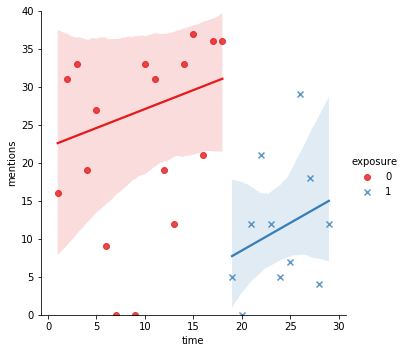

In [11]:
sns.lmplot(x="time", y="mentions", hue='exposure', data=data,
           markers=["o", "x"], palette="Set1",
           truncate=True, robust=False)

plt.ylim(0, 40)
plt.show()

In [12]:
data.to_csv('./assets/data.csv', index = False)